# Load Data File

In [15]:
# Check file directory
import os
print(os.getcwd())

/content


In [75]:
# Load data file
import pandas as pd

dataset = pd.read_csv('./sample_data/spam_ham_dataset.csv')
dataset

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


# Data Processing

In [17]:
# Display basic information about the dataset
print("Dataset Shape:", dataset.shape)
print("Columns:", dataset.columns.tolist())
print("Data Types:\n", dataset.dtypes)
print("Missing Values:\n", dataset.isnull().sum())

# Display the first few rows of the dataset
dataset.head()


Dataset Shape: (5171, 4)
Columns: ['Unnamed: 0', 'label', 'text', 'label_num']
Data Types:
 Unnamed: 0     int64
label         object
text          object
label_num      int64
dtype: object
Missing Values:
 Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [18]:
# Verify the column names
print("Original Columns:", dataset.columns)

# Rename the columns if necessary
column_mapping = {
    'Unnamed: 0': 'Index',
    'label': 'Email Type',
    'text': 'Email Text',
    'label_num': 'Label Number'
}

# Only rename columns that exist in the dataset
dataset.rename(columns={k: v for k, v in column_mapping.items() if k in dataset.columns}, inplace=True)

# Verify columns to ensure renaming was successful
print("Renamed Columns:", dataset.columns)


Original Columns: Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')
Renamed Columns: Index(['Index', 'Email Type', 'Email Text', 'Label Number'], dtype='object')


In [19]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Download wordnet data
nltk.download('averaged_perceptron_tagger')  # Download POS tagger data
nltk.download('punkt')  # Download tokenizer data
nltk.download('stopwords')  # Download stopwords data


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
import spacy

# Initialize NLP tools
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

# Add the words you want to remove to the stop words list
additional_stopwords = {"subject", "from", "to", "cc", "bcc", "forward", "by", "re", "fw"}
# Update additional_stopwords into stop words list
stop_words.update(additional_stopwords)


In [21]:
def process_sentence(sentence):
    nouns = []
    base_words = []
    final_words = []

    # Tokenize words for POS tagging
    words_2 = word_tokenize(sentence)

    # Clean the sentence
    sentence = re.sub(r'[^ \w\s]', '', sentence)
    sentence = re.sub(r'_', ' ', sentence)

    # Tokenize and POS tag the cleaned sentence
    words = word_tokenize(sentence)
    pos_tagged_words = pos_tag(words)

    # Lemmatize the words based on their POS tags
    for token, tag in pos_tagged_words:
        base_words.append(lemmatizer.lemmatize(token, tag_map[tag[0]]))

    # Remove stop words and compile final words
    for word in base_words:
        if word not in stop_words:
            final_words.append(word)

    sent = ' '.join(final_words)

    # Extract nouns
    pos_tagged_sent = pos_tag(words_2)
    for token, tag in pos_tagged_sent:
        if tag == 'NN' and len(token) > 1 and token not in stop_words:
            nouns.append(token)

    return sent, nouns

def clean_text(email):
    email = email.lower()
    sentences = sent_tokenize(email)
    total_nouns = []
    cleaned_email = ""

    # Process each sentence
    for sent in sentences:
        sentence, nouns = process_sentence(sent)
        cleaned_email += " " + sentence
        total_nouns += nouns

    # Remove additional stop words already added to stop_words set
    words = cleaned_email.split()
    final_words = [word for word in words if word not in stop_words]
    cleaned_email = ' '.join(final_words)

    return cleaned_email.strip(), total_nouns

def extract_entities(text):
    doc = nlp(text)
    entities = {}

    if doc.ents:
        for ent in doc.ents:
            label = ent.label_
            word = ent.text

            if label in entities:
                entities[label].append(word)
            else:
                entities[label] = [word]

        return entities
    else:
        return 'no'


In [22]:
def count_words(text):
    return len(word_tokenize(text))

def count_sentences(text):
    return len(sent_tokenize(text))

def count_entities(entities):
    if entities == 'no':
        return 0
    return sum(len(v) for v in entities.values())


In [23]:
def process_dataset(dataset):
    cleaned_texts = []
    all_nouns = []
    named_entities = []
    word_counts = []
    sentence_counts = []
    entity_counts = []

    for text in dataset['Email Text']:
        cleaned_text, nouns = clean_text(text)
        entities = extract_entities(text)

        cleaned_texts.append(cleaned_text)
        all_nouns.append(nouns)
        named_entities.append(entities)
        word_counts.append(count_words(text))
        sentence_counts.append(count_sentences(text))
        entity_counts.append(count_entities(entities))

    dataset['Cleaned Text'] = cleaned_texts
    dataset['Nouns'] = all_nouns
    dataset['Named Entities'] = named_entities
    dataset['Word Count'] = word_counts
    dataset['Sentence Count'] = sentence_counts
    dataset['Entity Count'] = entity_counts

    return dataset


In [24]:
# Process the dataset
processed_dataset = process_dataset(dataset)

# Display the first few rows of the processed dataset
processed_dataset.head()


,Index,Email Type,Email Text,Label Number,Cleaned Text,Nouns,Named Entities,Word Count,Sentence Count,Entity Count
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter 988291 follow note give m...,"[enron, methanol, note, monday, flow, daren, p...","{'ORG': ['enron'], 'CARDINAL': ['#', '988291',...",68,3,8
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl nom january 9 2001 see attach file hplnol ...,"[hpl, nom, file, hplnol, xls, hplnol, xls]","{'DATE': ['january 9 , 2001'], 'CARDINAL': ['0...",24,3,3
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat ho ho ho around wonderful time ye...,"[neon, retreat, ho, ho, ho, time, year, neon, ...","{'PERSON': ['ho ho ho', 'bobby'], 'DATE': ['th...",551,24,27
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trending a...,"[photoshop, office, cheap, trending, undergone...","{'PERSON': ['irvin', 'danielson']}",49,3,2
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,indian spring deal book teco pvr revenue under...,"[deal, book, teco, pvr, revenue, teco, check, ...",{'NORP': ['indian']},71,3,1


# To have better understanding for processed dataset
## Dataset contain email type

In [25]:
# Perform value counts on the 'Email Type' column
value_counts = dataset['Email Type'].value_counts()

# Display the value counts
value_counts


,count
Email Type,
ham,3672
spam,1499


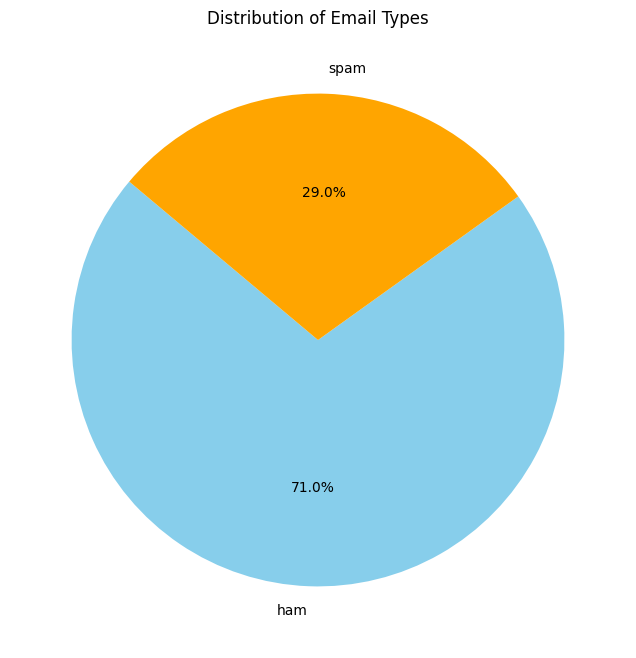

In [26]:
import matplotlib.pyplot as plt

# Perform value counts on the 'Email Type' column to see the distribution of labels
label_distribution = dataset['Email Type'].value_counts()

# Plot a pie chart to show the distribution of labels
plt.figure(figsize=(8, 8))
label_distribution.plot.pie(autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
plt.title('Distribution of Email Types')
plt.ylabel('')  # Hide y-label for better visualization
plt.show()


## Unigram Wordclouds

In [27]:
from nltk.util import ngrams

# Declare the N=gram function
def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []

    try:
      for grams in n_grams:
        returnVal.append('_'.join(grams))

    except(RuntimeError):
      pass

    return ' '.join(returnVal).strip()

# Put column 'Nouns' in a long string base on email type
def concatenate_nouns(dataset, email_type):
    nouns_string = []

    for index, row in dataset.iterrows():
      if row['Email Type'] == email_type:
        nouns_string.append(' '.join(row['Nouns']))

    long_noun_string = ' '.join(nouns_string)
    return long_noun_string

# Put column 'Cleaned Text' in a long string base on email type
def concatenate_cleaned_text(dataset, email_type):
    cleaned_text_string = []

    for index, row in dataset.iterrows():
      if row['Email Type'] == email_type:
        cleaned_text_string.append(row['Cleaned Text'])

    long_cleaned_text_string = ' '.join(cleaned_text_string)
    return long_cleaned_text_string

In [28]:
from matplotlib.pyplot import figure

# Define function to plot word cloud
def plot_cloud(wordcloud, title):
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.title(title)

    plt.show()
    plt.close()

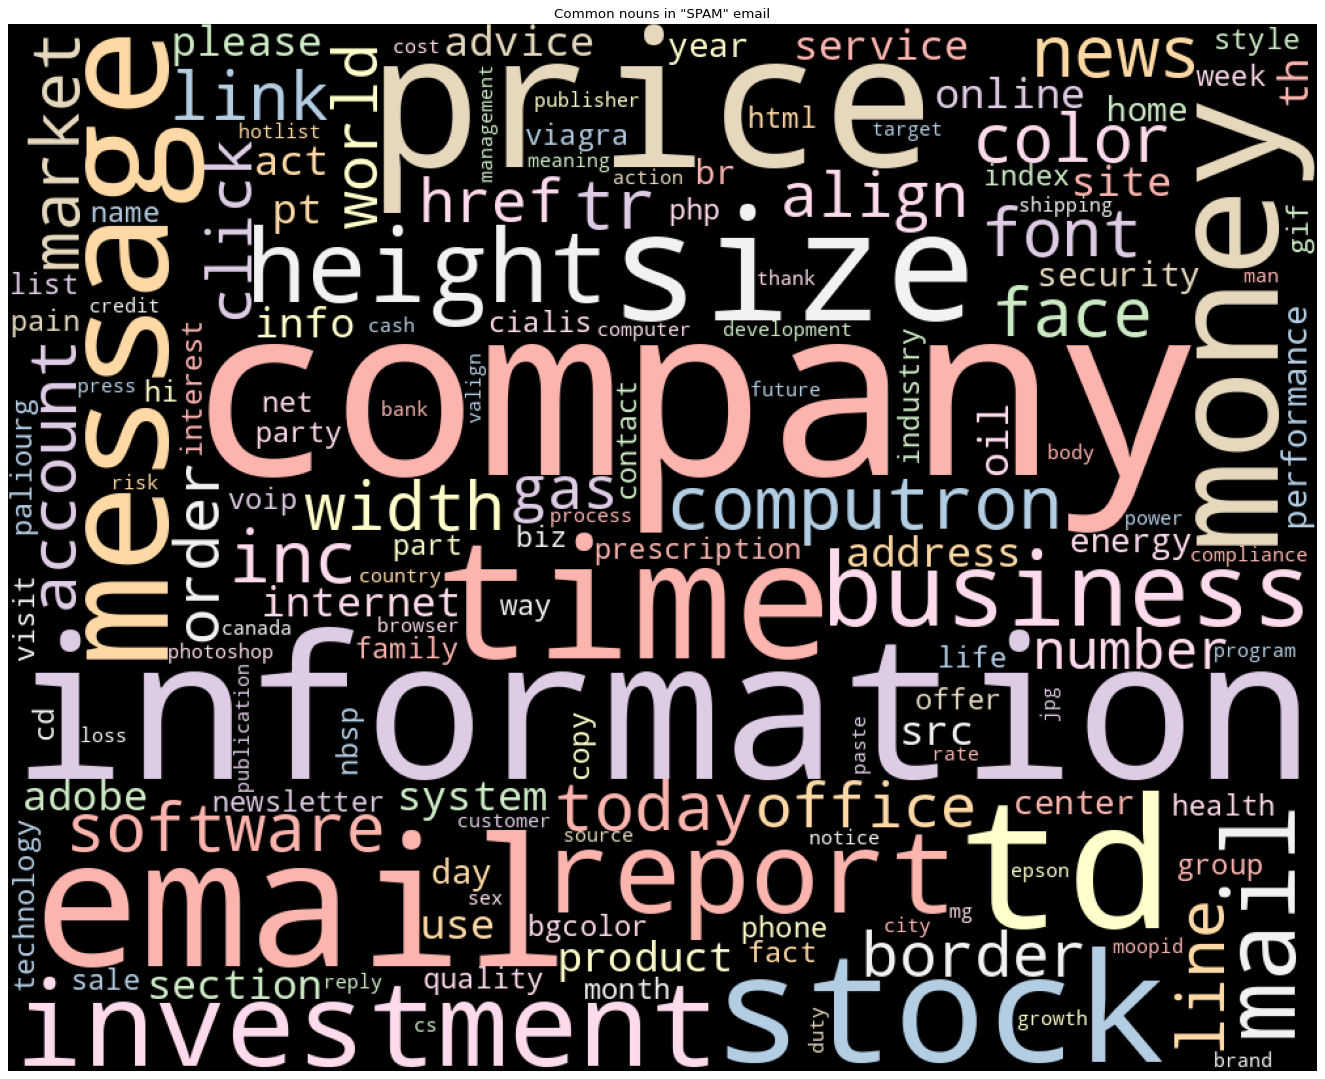

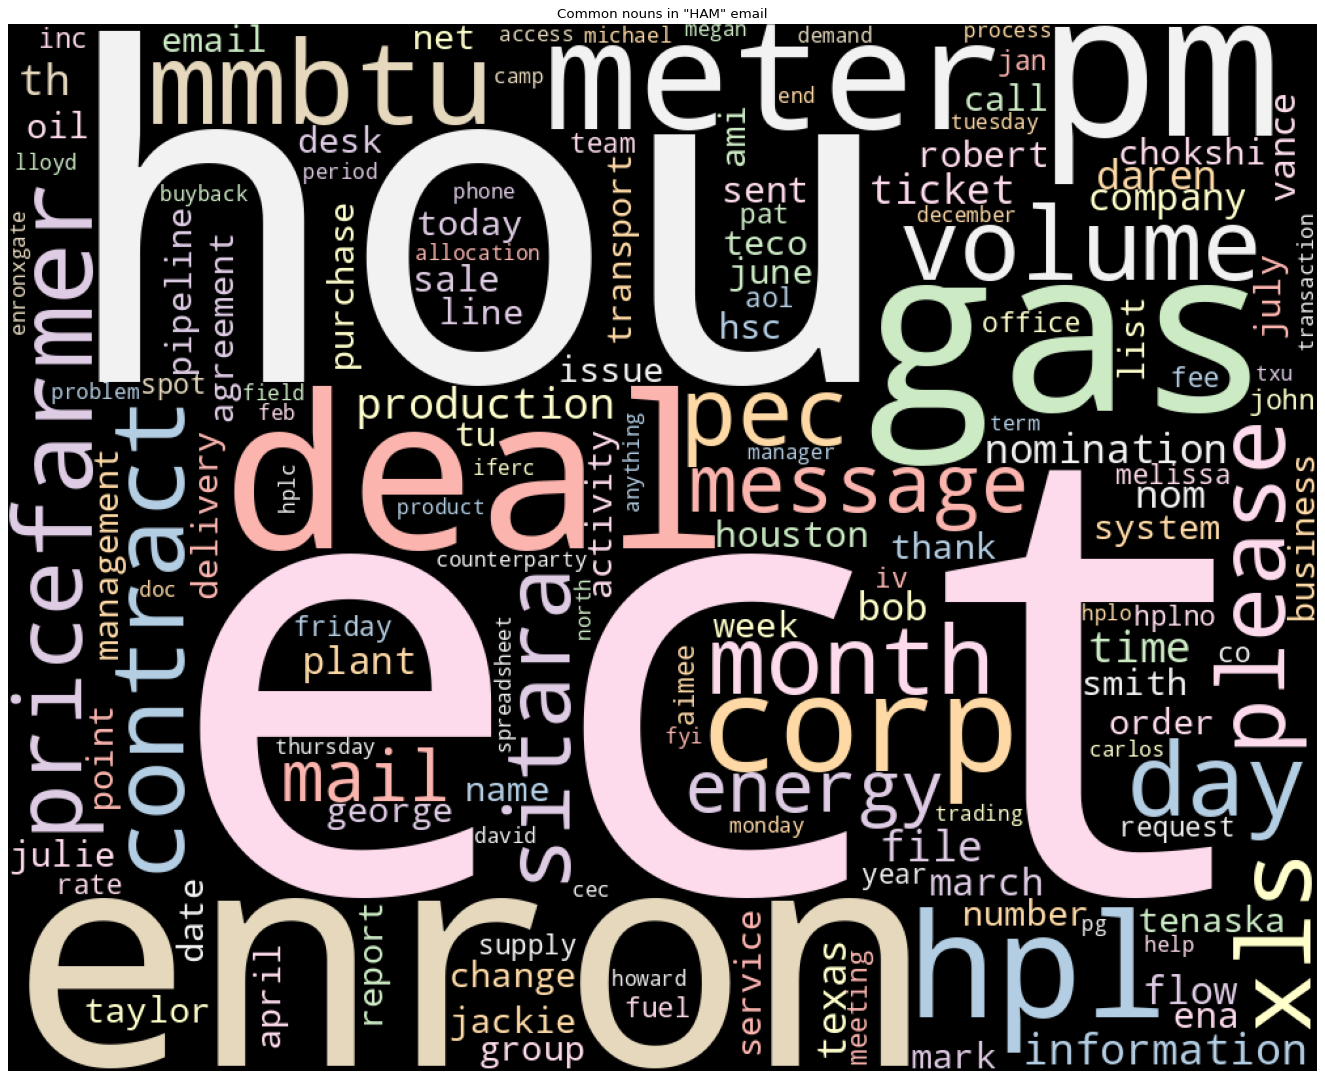

In [29]:
from wordcloud import WordCloud

# Concatenate nouns for "spam" and "ham" email
spam_nouns_string = concatenate_nouns(processed_dataset, "spam")
ham_nouns_string = concatenate_nouns(processed_dataset, "ham")

# Generate the unigram wordcloud object base on nouns
spam_nouns_wordcloud = WordCloud(width = 1000, height = 800, random_state=1, background_color='black', colormap='Pastel1',  max_words = 150, collocations=False, normalize_plurals=False).generate(spam_nouns_string)
ham_nouns_wordcloud = WordCloud(width = 1000, height = 800, random_state=1, background_color='black', colormap='Pastel1',  max_words = 150, collocations=False, normalize_plurals=False).generate(ham_nouns_string)

plot_cloud(spam_nouns_wordcloud, "Common nouns in \"SPAM\" email")
plot_cloud(ham_nouns_wordcloud, "Common nouns in \"HAM\" email")

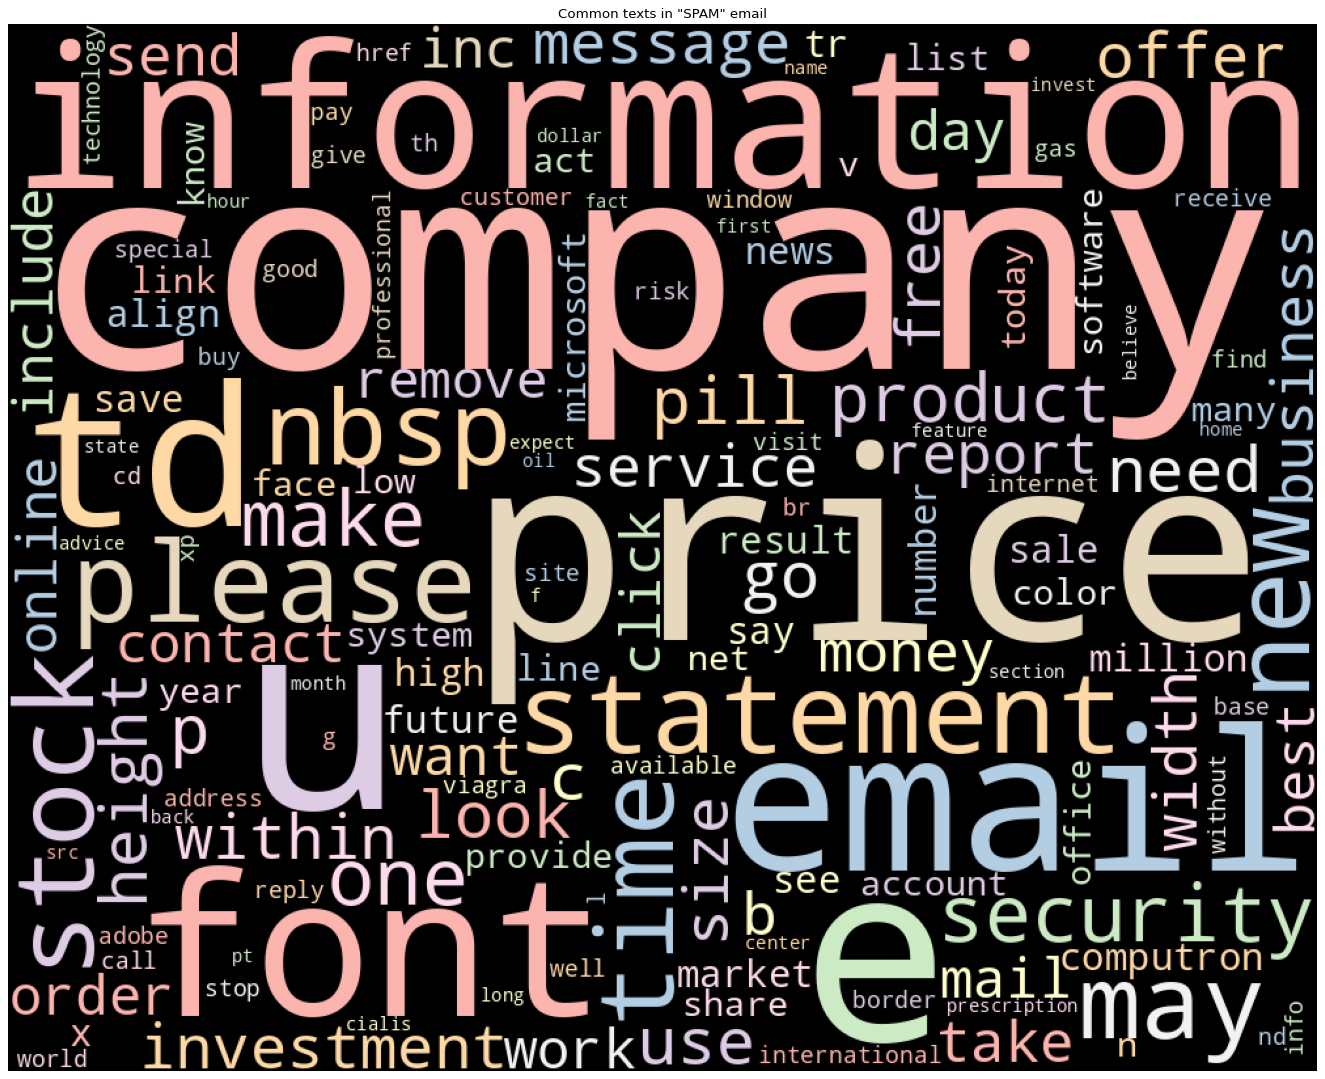

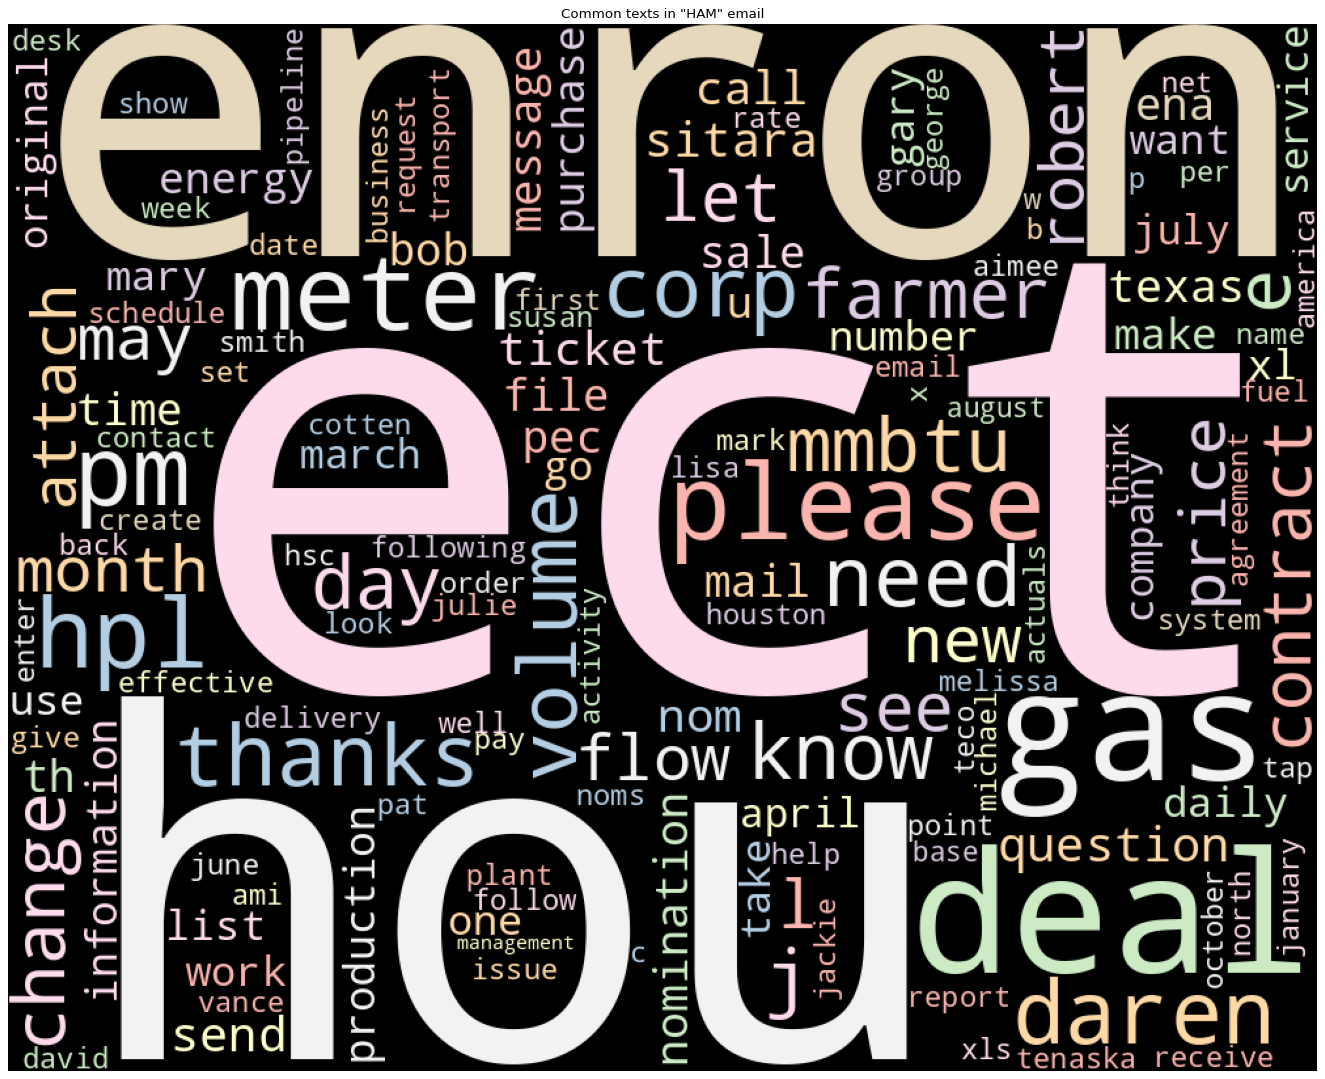

In [30]:
# Concatenate cleaned text for "spam" and "ham" email
spam_cleaned_text_string = concatenate_cleaned_text(processed_dataset, "spam")
ham_cleaned_text_string = concatenate_cleaned_text(processed_dataset, "ham")

# Generate the unigram wordcloud object base on cleaned text
spam_cleaned_text_wordcloud = WordCloud(width = 1000, height = 800, random_state=1, background_color='black', colormap='Pastel1',  max_words = 150, collocations=False, normalize_plurals=False).generate(spam_cleaned_text_string)
ham_cleaned_text_wordcloud = WordCloud(width = 1000, height = 800, random_state=1, background_color='black', colormap='Pastel1',  max_words = 150, collocations=False, normalize_plurals=False).generate(ham_cleaned_text_string)

plot_cloud(spam_cleaned_text_wordcloud, "Common texts in \"SPAM\" email")
plot_cloud(ham_cleaned_text_wordcloud, "Common texts in \"HAM\" email")

# Train Dataset Preparation

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    processed_dataset['Cleaned Text'], processed_dataset['Email Type'], test_size=0.2, random_state=42)


In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))

# Fit and transform the training data
train_x_vector = tfidf_vectorizer.fit_transform(X_train)
train_x_vector
# Transform the test data
test_x_vector = tfidf_vectorizer.transform(X_test)


In [93]:
#Support Vector Machine (SVM)

from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(train_x_vector, y_train)

print('Support vector machine:', svc.score(test_x_vector, y_test))

Support vector machine: 0.9932367149758454


In [95]:
#F1 score (using the SVC model)

from sklearn.metrics import f1_score

f1_score(y_test, svc.predict(test_x_vector), average=None)

array([0.99527984, 0.98807496])

In [97]:
# Train the final model with the best parameters
# best_svm_model = svc.best_estimator_
# best_svm_model.fit(train_x_vector, y_train)

# Make predictions on the test set
svm_predictions = svc.predict(test_x_vector)

# Evaluate the model
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Calculate the accuracy
svm_accuracy = svc.score(test_x_vector, y_test)
print("SVM Accuracy:", svm_accuracy)

SVM Classification Report:
               precision    recall  f1-score   support

         ham       1.00      0.99      1.00       742
        spam       0.99      0.99      0.99       293

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035

SVM Accuracy: 0.9932367149758454


# Training Models

## Random Forest

In [81]:
# Pipeline with text vectorization, scaling, and the Random Forest model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Scaling
    ('clf', RandomForestClassifier(random_state=42))
])

# Hyperparameters for GridSearchCV
rf_param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__bootstrap': [True]
}


In [94]:

# Perform GridSearchCV to find the best hyperparameters
rf_grid_search = GridSearchCV(pipeline, rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", rf_grid_search.best_params_)
print("Best Score:", rf_grid_search.best_score_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


KeyboardInterrupt: 

Random forest produces multiple decision trees, randomly choosing features to make decisions when splitting nodes to create each tree. It then takes these randomized observations from each tree and averages them out to build a final model.

In [ ]:
# Train the final model with the best parameters
rf_best_model = rf_grid_search.best_estimator_
rf_best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_best_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate the accuracy
rf_accuracy = rf_best_model.score(X_test, y_test)
print("Random Forest Accuracy:", rf_accuracy)


In [36]:
# Return random forest best training output
import pickle

filename = 'random_forest.pkl'
randomForestPickle = open(filename, 'wb')
pickle.dump(rf_best_model, randomForestPickle)
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9)),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=5, random_state=42))])

## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

# Pipeline with text vectorization, scaling, and the Logistic Regression model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Scaling
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# Hyperparameters for GridSearchCV
logreg_param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs']
}


In [38]:
# Perform GridSearchCV to find the best hyperparameters
logreg_grid_search = GridSearchCV(pipeline, logreg_param_grid, cv=3, n_jobs=-1, verbose=2)  # Reduced cv to 3 for faster execution
logreg_grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", logreg_grid_search.best_params_)
print("Best Score:", logreg_grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'clf__C': 1, 'clf__solver': 'liblinear', 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}
Best Score: 0.9830765441818023


In [39]:
# Train the final model with the best parameters
logreg_best_model = logreg_grid_search.best_estimator_
logreg_best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_best_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate the accuracy
logreg_accuracy = logreg_best_model.score(X_test, y_test)
print("Logistic Regression Accuracy:", logreg_accuracy)


Classification Report:
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       742
        spam       0.99      0.98      0.98       293

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035

Logistic Regression Accuracy: 0.9903381642512077


A confusion matrix is used to summarizes the performance of a Logistic Regression Model.

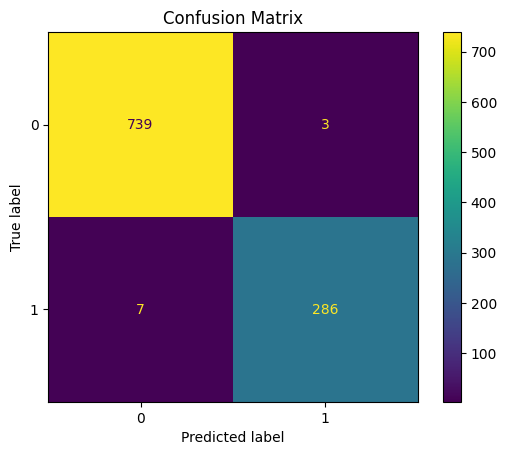

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, accuracy_score

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [42]:
# Return logistic regression best training output
filename = 'logistic_regression.pkl'
logisticRegressionPickle = open(filename, 'wb')
pickle.dump(logreg_best_model, logisticRegressionPickle)
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 LogisticRegression(C=1, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

## Support Vector Machine (SVM)

In [43]:
from sklearn.svm import SVC

# Define a pipeline with text vectorization, scaling, and the SVM model
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Scaling
    ('svm', SVC(probability=True, random_state=42))
])

# Define hyperparameters for GridSearchCV
svm_param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

In [44]:
# Perform GridSearchCV to find the best hyperparameters
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=3, n_jobs=-1, verbose=2)
svm_grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", svm_grid_search.best_params_)
print("Best Score:", svm_grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'svm__C': 0.1, 'svm__kernel': 'linear', 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
Best Score: 0.9613165623126355


In [45]:
# Train the final model with the best parameters
best_svm_model = svm_grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Make predictions on the test set
svm_predictions = best_svm_model.predict(X_test)

# Evaluate the model
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Calculate the accuracy
svm_accuracy = best_svm_model.score(X_test, y_test)
print("SVM Accuracy:", svm_accuracy)

SVM Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.97      0.98       742
        spam       0.93      0.95      0.94       293

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035

SVM Accuracy: 0.966183574879227


In [50]:
# Return SVM best training output
filename = 'svm.pkl'
svmPickle = open(filename, 'wb')
pickle.dump(best_svm_model, svmPickle)
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9)),
                ('scaler', StandardScaler(with_mean=False)),
                ('svm',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=42))])

## Naive Bayes

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [52]:
# Define a pipeline with text vectorization and the Naive Bayes model
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [53]:
# Define hyperparameters for GridSearchCV
nb_param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 1, 10]
}


In [54]:
# Perform GridSearchCV to find the best hyperparameters
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=3, n_jobs=-1, verbose=2)
nb_grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1, 1, 10], 'tfidf__max_df': [0.9, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [55]:
# Print the best parameters and best score
print("Best Parameters:", nb_grid_search.best_params_)
print("Best Score:", nb_grid_search.best_score_)


Best Parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}
Best Score: 0.9770319391045375


In [56]:
# Train the final model with the best parameters
best_nb_model = nb_grid_search.best_estimator_
best_nb_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.1))])

In [57]:
# Make predictions on the test set
nb_predictions = best_nb_model.predict(X_test)


In [58]:
# Evaluate the model
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))


Naive Bayes Classification Report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       742
        spam       0.99      0.94      0.97       293

    accuracy                           0.98      1035
   macro avg       0.99      0.97      0.98      1035
weighted avg       0.98      0.98      0.98      1035



In [59]:
# Calculate the accuracy
nb_accuracy = best_nb_model.score(X_test, y_test)
print("Naive Bayes Accuracy:", nb_accuracy)


Naive Bayes Accuracy: 0.9816425120772947


Naive Bayes is a probablistic machine learning algorithm that can be used in a wide variety of classification tasks.
It assumes that all features in the input data are independent of each other. Multinomial Naive Bayes deals with
text classifications where discrete data like word counts are involved.


In [61]:
# Return Naive Bayes best training output
filename = 'naive_bayes.pkl'
naiveBayesPickle = open(filename, 'wb')
pickle.dump(best_nb_model, naiveBayesPickle)
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.1))])

## K-Nearest Neighbour (KNN)

In [62]:
# K-Nearest Neighbour
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier

In [63]:
# Define a pipeline with text vectorization, scaling, and the KNN model
knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Scaling
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Define hyperparameters for GridSearchCV
knn_param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

In [64]:
# Perform GridSearchCV to find the best hyperparameters
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, n_jobs=-1, verbose=2)
knn_grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", knn_grid_search.best_params_)
print("Best Score:", knn_grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'knn__metric': 'euclidean', 'knn__weights': 'distance', 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
Best Score: 0.46058894334921535


In [65]:
# Train the final model with the best parameters
best_knn_model = knn_grid_search.best_estimator_best_knn_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9)),
                ('scaler', StandardScaler(with_mean=False)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', weights='distance'))])

In [66]:
# Calculate the accuracy
knn_accuracy = best_knn_model.score(X_test, y_test)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.5111111111111111


In [67]:
# Make predictions on the test set
knn_predictions = best_knn_model.predict(X_test)

In [68]:
# Evaluate the model
print("KNN Classification Report:\n", classification_report(y_test, knn_predictions))

KNN Classification Report:
               precision    recall  f1-score   support

         ham       1.00      0.32      0.48       742
        spam       0.37      1.00      0.54       293

    accuracy                           0.51      1035
   macro avg       0.68      0.66      0.51      1035
weighted avg       0.82      0.51      0.50      1035



The K-Nearest Neighbour model works by finding the "distance" between all the data points. The distance between those data points are recorded and sorted to find a k number of nearest data points. Among these 'K' nearest neighbors, the new data point is assigned the class that is most frequent among the neighbors.

In [71]:
# Return K-Nearest Neighbour best training output
filename = 'knn.pkl'
knnPickle = open(filename, 'wb')
pickle.dump(best_knn_model, knnPickle)
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9)),
                ('scaler', StandardScaler(with_mean=False)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', weights='distance'))])

# Return Vectorizer Filename

In [ ]:
# Save the TfidfVectorizer
vectorizer_filename = 'tfidf_vectorizer.pkl'
with open(vectorizer_filename, 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

# Others

In [ ]:
!pip install pickle5


In [ ]:
import pickle

knnPickle = open('knnpickle_file', 'wb')
pickle.dump(best_knn_model, knnPickle)
knnPickle.close()